Array measurements ROBAT 226.238:
- 5 mic array adafruit 5 i2s 
- 96khz 
- 2 meters distance (~ far field = 10𝛌; 𝛌max = 343/2 = 171 Hz --> 10𝛌 = 1715 Hz )
- measured clockwise (R: 0-90; L: 270-360)
- array rotated around the central mic kept a 2m from source

HW settings:
- AWR 445 vol = -40 db
- fireface analog out 1/2 stereo vol = 0db
- tweeter #1

Out signal: 1-40Khz sweep

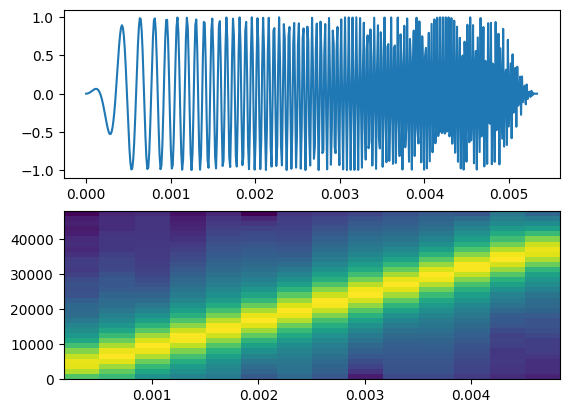

Chirped 1
Chirped 2
Chirped 3
Chirped 4
Chirped 5


In [22]:
import sounddevice as sd
import numpy as np
import scipy.signal as signal
import time
from matplotlib import pyplot as plt

def get_soundcard_outstream(device_list):
    for i, each in enumerate(device_list):
        dev_name = each['name']
        asio_in_name = 'MCHStreamer' in dev_name
        if asio_in_name:
            return i

def pow_two_pad_and_window(vec, show = True):
    window = signal.windows.tukey(len(vec), alpha=0.2)
    windowed_vec = vec * window
    padded_windowed_vec = np.pad(windowed_vec, (0, 2**int(np.ceil(np.log2(len(windowed_vec)))) - len(windowed_vec)))
    if show:
        dur = len(padded_windowed_vec) / fs
        t = np.linspace(0, dur, len(windowed_vec))
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(t, windowed_vec)
        plt.subplot(2, 1, 2)
        plt.specgram(windowed_vec, NFFT=64, noverlap=32, Fs=fs)
        plt.show()
    return padded_windowed_vec/max(padded_windowed_vec)

def pow_two(vec):
    return np.pad(vec, (0, 2**int(np.ceil(np.log2(len(vec)))) - len(vec)))

if __name__ == "__main__":

    fs = 96e3
    dur = 5e-3
    hi_freq =  1e3
    low_freq = 40e3
    n_sweeps = 5
    
    t_tone = np.linspace(0, dur, int(fs*dur))
    chirp = signal.chirp(t_tone, hi_freq, t_tone[-1], low_freq)
    sig = pow_two_pad_and_window(chirp, show=True)

    silence_dur = 100 # [ms]
    silence_samples = int(silence_dur * fs/1000)
    silence_vec = np.zeros((silence_samples, ))
    full_sig = pow_two(np.concatenate((sig, silence_vec)))
    #print('len = ', len(full_sig))
    stereo_sig = np.hstack([full_sig.reshape(-1, 1), full_sig.reshape(-1, 1)])

    output_sig = np.float32(stereo_sig)

    current_frame = 0
    def callback(outdata, frames, time, status):
        global current_frame
        if status:
            print(status)
        chunksize = min(len(output_sig) - current_frame, frames)
        outdata[:chunksize] = output_sig[current_frame:current_frame + chunksize]
        if chunksize < frames:
            outdata[chunksize:] = 0
            raise sd.CallbackAbort()
        current_frame += chunksize

    device = get_soundcard_outstream(sd.query_devices())
    
    try:
        for i in range(n_sweeps): 
            stream = sd.OutputStream(samplerate=fs,
                        blocksize=0,
                        device=device,
                        channels=2,
                        callback=callback,
                        latency='low')
                
            with stream:
                while stream.active:
                    pass

            current_frame = 0
            print('Chirped %d' % (i+1))
            time.sleep(1)

    except KeyboardInterrupt:
        print('Interrupted by user')
